# Card Value Classifier

In this notebook we will discuss how the card value classifier was trained.

In the project main notebook, you have seen that the notebook just imported the trained classifier
and use it to classify the value of the card. The classifier is a multi-layer perceptron
`MLPClassifier` from scikit-lean library.

## 1. Data

To train an MLP, we need a lot of data. The value on the card consisted of 13 values. $[0-9, J, Q, K]$.

The $[0-9]$ value on the card was taken from the MNIST images. So, we downloaded the MNIST database
and included the 60,000 training images into out training dataset.

For the $[J, K, Q]$, we cropped the figure for each value from the `./media/example_cards.png`.
Then, we invert the images to be white on black background; as same as the MNIST. Also, since the
figure can also be upside down during game play, we add the upside down figure to the training data.

Currently, we have total of 6 images; 3 classes, 2 images for each class. Which is insufficient to use
for training. We need to generate more training data and we used `ImageDataGenerator` from
`tensorflow.keras` library. `ImageDataGenerator` will generate images that is rotated, skewed,
discolored, etc. from the given image.

So, we generated 3000 more images for each image, each of them will be either randomly rotated within 8 degrees,
sheared within 5 degree, brightness varied from 0.9 to 1.0 times the original image or zoomed 0.9 to 1.3 times
the original size or in any combination of above.

For the $[J, K, Q]$ classes, we will have 18,000 images for training which includes 6,000 images for each class,
half of which are upside down. We also generated 3,000 more images for testing.

In total, we have 60,000 + 18,000 = 78,000 images for training a classifier to classify 13 classes.

Let's get to the coding. First, we import the libraries we need.

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.neural_network import MLPClassifier

import numpy as np
import pickle
import cv2
import os
import gzip
import zipfile
from matplotlib.pyplot import imread, imshow, subplots, show
%matplotlib inline

We define a function to help us extract the MNIST data, a function to turns image into vector for training
and vice versa.

In [2]:
def extract_data(filename, image_shape, image_number):
    with gzip.open(filename) as bytestream:
        bytestream.read(16)
        buf = bytestream.read(np.prod(image_shape) * image_number)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
        data = data.reshape(image_number, image_shape[0], image_shape[1])
    return data

def extract_labels(filename, image_number):
    with gzip.open(filename) as bytestream:
        bytestream.read(8)
        buf = bytestream.read(1 * image_number)
        labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
    return labels

def vector_encode(images_stack):
    return images_stack.reshape(images_stack.shape[0],images_stack.shape[1]*images_stack.shape[2])

def vector_decode(vector_stack):
    return vector_stack.reshape((vector_stack.shape[0], 28, 28))


Now we will load the 6 images. One-by-one, we will setup the `ImageDataGenerator` and generate some
samples and label for training and testing.

In [3]:
data_figure_card = []
label_figure_card = []

data_figure_card_test = []
label_figure_card_test = []

# For each of the 6 figure image, we load it and generate 3000 train and 500 test samples
for img in os.listdir('./data/training/card_fig'):

    # specify the class from file name
    if img == 'k1' or img == 'k2':
        card_name = 12
    elif img == 'q1' or img == 'q2':
        card_name = 11
    elif img == 'j1' or img == 'j2':
        card_name = 10

    # Load the image
    img = cv2.imread('./data/training/card_fig/'+img, cv2.IMREAD_GRAYSCALE)
    imgs = img.reshape((1, img.shape[0], img.shape[1], 1))

    # Setup the ImageDataGenerator
    data_generator = ImageDataGenerator(rotation_range=8, brightness_range=(0.9, 1.0), shear_range=5.0, zoom_range=[0.9, 1.3])
    data_generator.fit(imgs)
    image_iterator = data_generator.flow(imgs)

    # Generate some sample for training
    for x in range(3000):
        img_transformed=image_iterator.next()[0].astype('float32')
        img_transformed = img_transformed.reshape(28,28)
        data_figure_card.append(img_transformed)
        label_figure_card.append(card_name)

    # Generate some sample for training
    for x in range(500):
        img_transformed=image_iterator.next()[0].astype('float32')
        img_transformed = img_transformed.reshape(28,28)
        data_figure_card_test.append(img_transformed)
        label_figure_card_test.append(card_name)

Then, we shuffle the images (and the label) and turns it into an array for further processing.

In [4]:
# Shuffle and turns it into np array for training set
idx = np.random.permutation(len(data_figure_card))
data_figure_card = np.array(data_figure_card)[idx]
label_figure_card = np.array(label_figure_card)[idx]

# Shuffle and turns it into np array for testing set
idx = np.random.permutation(len(data_figure_card_test))
data_figure_card_test = np.array(data_figure_card_test)[idx]
label_figure_card_test = np.array(label_figure_card_test)[idx]

Let's see some generated image from the training set

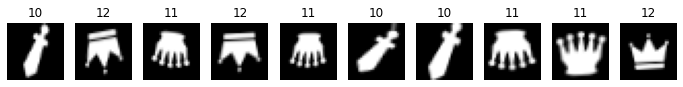

In [5]:
prng = np.random.RandomState()
plt_ind = prng.randint(low=0, high=18000, size=10)

fig, axes = subplots(1, 10, figsize=(12, 3))
for ax, im, lb in zip(axes, data_figure_card[plt_ind], label_figure_card[plt_ind]):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(lb)

After we have prepared the $[J,Q,K]$ figure, we'll now prepare the $[0,1,2,...,9]$ images from the
MNIST dataset.

In [6]:
# Load MNIST
image_shape = (28, 28)
train_set_size = 60000
test_set_size = 10000

# data_part2_folder = os.path.join(data_base_path, data_folder, 'project')
data_project_folder = './data/training/MNIST/'
train_images_path = os.path.join(data_project_folder, 'train-images-idx3-ubyte.gz')
train_labels_path = os.path.join(data_project_folder, 'train-labels-idx1-ubyte.gz')
test_images_path = os.path.join(data_project_folder, 't10k-images-idx3-ubyte.gz')
test_labels_path = os.path.join(data_project_folder, 't10k-labels-idx1-ubyte.gz')

train_images = extract_data(train_images_path, image_shape, train_set_size)
test_images = extract_data(test_images_path, image_shape, test_set_size)
train_labels = extract_labels(train_labels_path, train_set_size)
test_labels = extract_labels(test_labels_path, test_set_size)

We then combine the generated $[J,Q,K]$ images and the $[0,1,2,...,9]$ from MNIST dataset and shuffle
it.

In [7]:
# Combine the data set and shuffle
# Training
train_images = np.concatenate((train_images, data_figure_card), axis=0)
train_labels = np.concatenate((train_labels, label_figure_card), axis=0)

idx = np.random.permutation(len(train_images))
train_images = train_images[idx]
train_labels = train_labels[idx]

# Testing
test_images = np.concatenate((test_images, data_figure_card_test), axis=0)
test_labels = np.concatenate((test_labels, label_figure_card_test), axis=0)

idx = np.random.permutation(len(test_images))
test_images = test_images[idx]
test_labels = test_labels[idx]

Let's see the result of the combined training dataset.

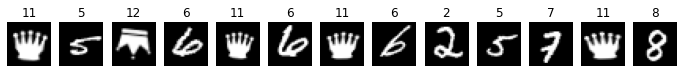

In [8]:
# Check
prng = np.random.RandomState()
plt_ind = prng.randint(low=0, high=train_set_size + 18000, size=13)

fig, axes = subplots(1, 13, figsize=(12, 3))
for ax, im, lb in zip(axes, train_images[plt_ind], train_labels[plt_ind]):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(lb)

We then prepare the training and testing images for the classifier by vector encode them.

In [9]:
train_images_vector_encoded = vector_encode(train_images)
test_images_vector_encoded = vector_encode(test_images)

## 2. Model Training
Now, have all the data we need in the correct format. We will create and train an MLP classifier
with `MLPClassifier`.

The MLP that we will create have two hidden layers with 256 nodes each.
After each layer, we pass the value through $relu$ activation function.

We will use `adam` optimizer with a learning rate of $0.001$ to optimize the weight and bias. We set the
`alpha` or $L_2$ penalty which is a regularization term to $0.01$

In [22]:
mlp = MLPClassifier(hidden_layer_sizes=(256, 256),      # 2 hidden layers 256 nodes each
                    activation='relu',                  # use relu activation after every layer
                    alpha=0.01,                         # L2 penalty set as 0.01
                    solver='adam',                      # Use Adam optimization method
                    learning_rate_init=0.001,           # with 0.001 learning rate
                    max_iter=200,                       # Train the model for 200 iterations,
                    early_stopping=True,                # but stop it if the loss does not reduce
                    tol=0.0001,                         # more than 0.0001 for 10 consecutive iterations.
                    verbose=False)

mlp.fit(train_images_vector_encoded, train_labels)      # Train the model

train_score = mlp.score(train_images_vector_encoded, train_labels)    # Evaluate with training dataset
test_score = mlp.score(test_images_vector_encoded, test_labels)      # Evaluate with testing dataset

print("Training accuracy: {:.2f}, Testing accuracy: {:.2f}".format(train_score*100, test_score*100))

Training accuracy: 99.45, Testing accuracy: 98.05


As we can see, we are able to achieve over 99% accuracy on the training set and over 98% on the testing set.
*Result may vary between each run*

## 3. Saving the model and data for later use
We ran the training couples of times and obtained the best model that achieve 99.7% on the training set and 98.2%
on the testing set.

We saved the model with `pickle.dump`.

*To actually save the result from this run, set* `please_save` *to* `True`*. Note that it will overwrite the saved model*

In [11]:
please_save = False

if please_save:
    filename = './data/value_classifier_256_995_980.mdl'
    pickle.dump(mlp, open(filename, 'wb'))

To save the training and testing data. We can use `numpy.save`


In [12]:
if please_save:
    np.save('./data/training/training_data_vector_encoded.npy', train_images_vector_encoded)
    np.save('./data/training/training_label.npy', train_labels)
    np.save('./data/training/testing_data_vector_encoded.npy', test_images_vector_encoded)
    np.save('./data/training/testing_label.npy', test_labels)

## 4. Load the model
We can load the saved model with `pickle.load` into `loaded_model` object.

In [17]:
filename = './data/value_classifier_256_995_980.mdl'
loaded_model = pickle.load(open(filename, 'rb'))

c:\users\tecni\appdata\local\programs\python\python39\lib\site-packages\sklearn\base.py:310: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.24.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
c:\users\tecni\appdata\local\programs\python\python39\lib\site-packages\sklearn\base.py:310: UserWarning: Trying to unpickle estimator MLPClassifier from version 0.24.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


We can load the saved dataset with `numpy.load`. The saved images are vector encoded and it is not suitable for
visualizing. So, we need to decode them back into image.

Note that our saved data are very big, so we compressed them into a zip file and we need to extract it first.

In [18]:
import zipfile
with zipfile.ZipFile('./data/training/project_dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('./data/training/')

test_images_vector_encoded = np.load('./data/training/testing_data_vector_encoded.npy')
test_labels = np.load('./data/training/testing_label.npy')
test_images = vector_decode(test_images_vector_encoded)

Let's use our pre-trained model to do some prediction from some random samples from the testing set.

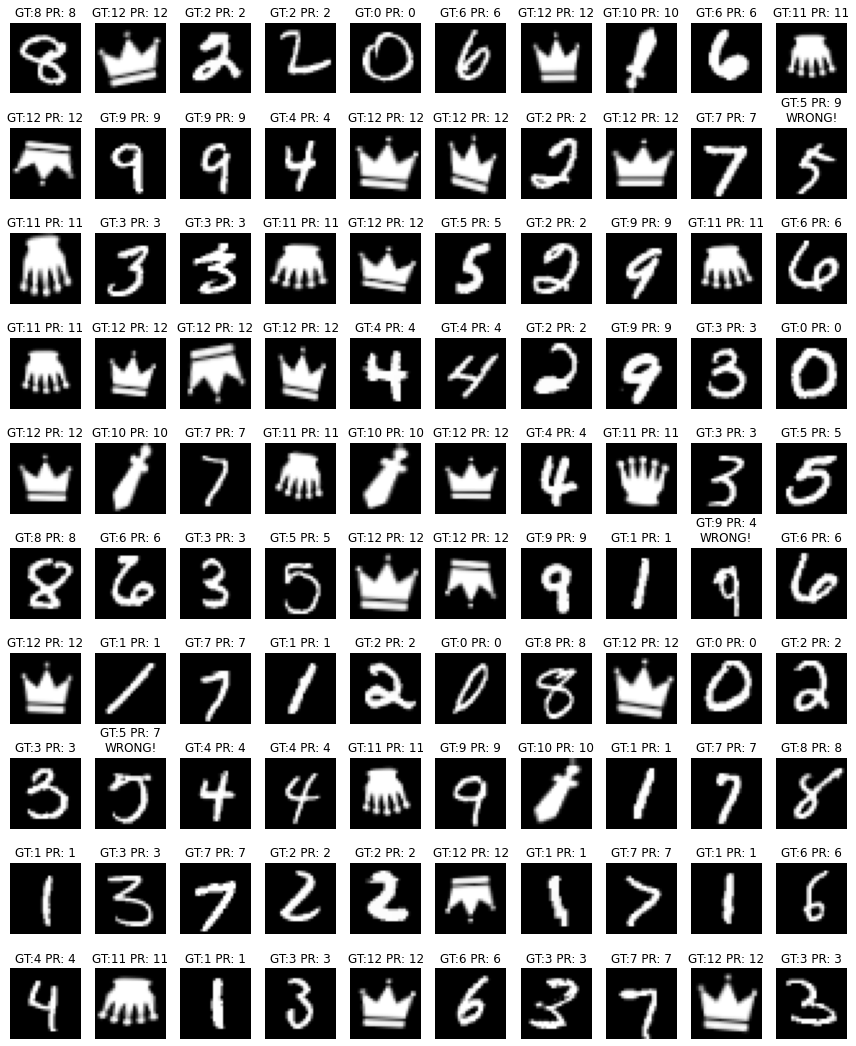

In [27]:
# Randomly pick some image from the test set
prng = np.random.RandomState()
plt_ind = prng.randint(low=0, high=10000, size=100)

# Vector encode the chosen samples
test_samples = test_images_vector_encoded[plt_ind]

# Predict the given samples
prediction = loaded_model.predict(test_samples)

# Ground truth
groundTruth = test_labels[plt_ind]

# Show the resulting prediction
fig, axes = subplots(nrows=10, ncols=10, figsize=(15, 19))
for i in range(0, 10):
    for j in range(0,10):
        axes[i,j].imshow(test_images[plt_ind][10*i+j], cmap='gray')
        axes[i,j].axis('off')
        if (groundTruth[10*i+j] != prediction[10*i+j]):
            axes[i,j].set_title("GT:{} PR: {}\nWRONG!".format(groundTruth[10*i+j], prediction[10*i+j]))
        else:
            axes[i,j].set_title("GT:{} PR: {}".format(groundTruth[10*i+j], prediction[10*i+j]))

As we can see from the prediction result on the testing set, classifier mis-classified three out of 100 samples.
Which is close to the 98% accuracy of the testing set.